[In English](../use-case_oafeat-script_en/)  

![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)  

[TdM](https://eccc-msc.github.io/open-data/readme_fr/) > [Aperçu de l'utilisation](https://eccc-msc.github.io/open-data/usage/readme_fr/) > Requêtes OGC API - Features avec Python (version script)

# Cas d'utilisation: Récupération et affichage de données hydrométriques

## Introduction

Les données hydrométriques du Service météorologique du Canada (SMC) d'Environnement et Changement climatique Canada (ECCC) peuvent être facilement accédées via [GeoMet-OGC-API](https://api.weather.gc.ca/). Les services web [OGC API - Features](https://eccc-msc.github.io/open-data/msc-geomet/web-services_fr/#ogc-api-features) disponibles dans GeoMet-OGC-API permettent d'effectuer des requêtes de données géospatiales vectorielles et de récupérer ces données en format GeoJSON. Les fichiers GeoJSON peuvent ensuite être utilisés directement pour réaliser des analyses et afficher les données sur des cartes ou peuvent être soumis à des étapes supplémentaires de traitement de données. Ce cas d'utilisation démontre comment: 
* Effectuer des requêtes et récupérer des données géospatiales vectorielles disponibles dans GeoMet-OGC-API à l'aide de [Python](https://www.python.org/)
* Afficher des données de séries temporelles en format graphique et tabulaire
* Créer une carte interactive présentant les données géospatiales récupérées

Ce cas d'utilisation est disponible en deux versions. Cette version-ci a été concue pour être utilisé de manière traditionnelle dans un terminal ou un environnement de développement intégré, mais peut également être utilisé dans [Jupyter Notebook](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case_oafeat-script_fr.ipynb). Si vous recherchez plus d'éléments interactifs tels que des menus déroulants pour sélectionner la valeur des variables, un graphique interactif comportant une plus grande variété de fonctions et une carte interactive basée sur Leaflet, [l'autre version de ce cas d'utilisation](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case_oafeat-interactive_fr.ipynb) conçue spécialement pour Jupyter Notebook pourrait vous intéresser.

[Une version exécutable de ce cas d'utilisation est disponible.](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case_oafeat-script_fr.ipynb) Dans Jupyter Notebook, cliquez sur le symbole ⏩️ ou sélectionnez l'option *Cell* -> *Run All* dans la barre de menu pour exécuter l'entièreté de ce carnet. Si les annotations ne sont pas visibles lors du passage de la souris sur le graphique ou sur la carte, exécutez à nouveau la cellule contenant le code du graphique ou de la carte en cliquant dans la cellule puis en cliquant sur le bouton Exécuter dans la barre de menu.

**Note importante:** Hors de Jupyter Notebook, la commande magique ```%matplotlib notebook``` située à la fin de la section du code portant sur les paramètres doit être retirée.

[![badge](https://img.shields.io/badge/Version%20ex%C3%A9cutable-binder-F5A252.svg?logo=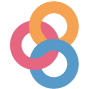)](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case_oafeat-script_fr.ipynb)


## Création d'un outil pour suivre l'évolution des niveaux d'eau 

Cathy dirige une compagnie d'excursions en bateau et de sports nautiques à Chilliwack en Colombie-Britannique. Elle aimerait suivre le niveau d'eau de certaines stations hydrométriques situés près de Chilliwack afin de guider la gestion des activités de sa compagnie. Elle aimerait obtenir:
* Les moyennes journalières de niveau d'eau pour une période de trois mois pour toutes les stations hydrométriques situées dans un rayon de 100 km de Chilliwack
* Une vue graphique et tabulaire des moyennes journalières de niveau d'eau de cette période
* Une carte interactive présentant les stations hydrométriques situées dans un rayon de 100 km de Chilliwack et la moyenne journalière de niveau d'eau la plus récente de ces stations pour la période temporelle sélectionnée

Pour y arriver, la première étape est d'importer les modules Python nécessaires et de sélectionner les paramètres de requête désirés.

In [1]:
# Importation des modules
from datetime import date
import json
import locale
import math
from textwrap import fill

import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
from matplotlib import pyplot as plt, dates as mdates
from osgeo import ogr, osr
from owslib.ogcapi.features import Features
import numpy as np
import pandas as pd
from tabulate import tabulate

In [2]:
# Paramètres

# Coordonnées de Chilliwack
lat = 49.162676
long = -121.958943

# Taille de la zone tampon en kilomètres
buffer = 100

# Dates de début et de fin de la période temporelle pour
# laquelle des données seront récupérées
start_date = date(2018, 6, 1)
end_date = date(2018, 8, 31)

# Code ESPG de la projection désirée pour crééer la zone tampon
# NAD83 / Statistiques Canada Lambert
projection = 3347

# Commentez la ligne suivante si vous utilisez le code hors de Jupyter Notebook
%matplotlib notebook

In [3]:
# Formattage des paramètres pour la requête OGC API - Features

# Zone de délimitation légèrement plus grande que la taille de la zone tampon

# La taille de la zone tampon doit être transformée en degrés afin d'obtenir
# les coordonnées des coins de la zone de délimitation:
# Latitude: 1 km ≈ 0.009° 
# Longitude (au 49e parallèle): 1 km ≈ 0.014°
bbox = [
    str(long - buffer * 0.02),
    str(lat - buffer * 0.01),
    str(long + buffer * 0.02),
    str(lat + buffer * 0.01),
]

# Formattage de la période temporelle sélectionnée
time = f"{start_date}/{end_date}"

# Formattage des dates en français pour le graphique
locale.setlocale(locale.LC_ALL, "fr")

'fr'

Ensuite, les [données des stations hydrométriques](https://geo.weather.gc.ca/geomet/features/collections/hydrometric-stations) disponibles sur GeoMet-OGC-API peuvent être récupérées à l'aide d'[OWSLib](https://geopython.github.io/OWSLib/). Comme l'utilisation d'une zone de délimitation à l'aide du paramètre ```bbox``` n'est pas aussi précise que l'utilisation d'une zone tampon ronde, [GDAL](https://gdal.org/api/index.html#python-api) peut être utilisé pour sélectionner uniquement les stations hydrométriques situées strictement dans un rayon de 100 km de Chilliwack.

In [4]:
# Récupération des données de stations hydrométriques
oafeat = Features("https://api.weather.gc.ca/")
station_data = oafeat.collection_items(
    "hydrometric-stations", bbox=bbox, STATUS_EN="Active"
)

# Vérification des données récupérées
if "features" in station_data.keys() and station_data["features"]:
    station_data = json.dumps(station_data, indent=4)
else:
    raise ValueError(
        "Aucune station hydrométrique n'a été trouvée. "
        + "Veuillez revérifier les coordonnées."
    )

In [5]:
# Liste des stations situées dans la zone tampon

# Accéder à la couche de stations hydrométriques
driver = ogr.GetDriverByName("GeoJSON")
data_source = driver.Open(station_data, 0)
layer = data_source.GetLayer()

# Identification du système de référence spatiale (SRS) d'entrée
SRS_input = layer.GetSpatialRef()
SR = osr.SpatialReference(str(SRS_input))
epsg = SR.GetAuthorityCode(None)
SRS_input.ImportFromEPSG(int(epsg))

# Définition du SRS utilisé pour projeter les données
SRS_projected = osr.SpatialReference()
SRS_projected.ImportFromEPSG(projection)

# Transformation du SRS d'entrée à la projection désirée
transform = osr.CoordinateTransformation(SRS_input, SRS_projected)

# Création de la zone tampon pour sélectionner les stations
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(long, lat)
point.Transform(transform)
point_buffer = point.Buffer(buffer * 1000)  # La valeur doit être en mètres

# Sélection des stations situées dans la zone tampon
stations = []

for feature in layer:
    geom = feature.GetGeometryRef().Clone()
    geom.Transform(transform)
    if geom.Intersects(point_buffer):
        stations.append(feature.STATION_NUMBER)

# Générer une erreur si aucune station n'est trouvée
if not stations:
    raise ValueError(
        f"Aucune station hydrométrique n'est située dans un rayon de {buffer}"
        + " km des coordonnées choisies. Veuillez vérifier les coordonnées."
    )

Une fois les stations hydrométriques situées dans un rayon de 100 km de Chilliwack identifiées, les données de niveau d'eau pour la période de trois mois peuvent êtres récupérées pour chaque station.

Les moyennes journalières de niveau d'eau de la période de trois mois seront utilisées pour créer une trame de données pour chaque station à l'aide de [Pandas](https://pandas.pydata.org/). Pour faciliter la manipulation des données, l'ensemble des trames de données sera rassemblée dans un dictionnaire Python. Ces trames de données seront utilisées pour créer des graphiques interactifs et des tableaux affichant les données historiques de niveau d'eau ainsi qu'une carte interactive présentant les données les plus récentes pour la période temporelle sélectionnée.

Les stations n'ayant aucune donnée de niveau d'eau disponible durant la période choisie seront retirées du jeu de données.

In [6]:
# Récupération des données hydrométriques pour chaque station

# Dictionnaire qui contiendra une trame de données de niveau
# d'eau pour chaque station
hydrometric_data = {}

# Liste des stations n'ayant aucune donnée de niveau d'eau 
stations_without_data = []

# Récupération des données et création des trames de données
for station in stations:

    # Récupération des données de niveaux d'eau
    hydro_data = oafeat.collection_items(
        "hydrometric-daily-mean",
        bbox=bbox,
        datetime=f"{start_date}/{end_date}",
        STATION_NUMBER=station,
    )
    # Création des trames de données s'il y a 
    # des données pour la période choisie
    if hydro_data["features"]:
        # Création d'un dictionnaire dans un format compatible avec Pandas
        historical_data_format = [
            {
                "LATITUDE": el["geometry"]["coordinates"][1],
                "LONGITUDE": el["geometry"]["coordinates"][0],
                **el["properties"],
            }
            for el in hydro_data["features"]
        ]
        # Création d'une trame de données à partir du dictionnaire
        historical_data_df = pd.DataFrame(
            historical_data_format,
            columns=[
                "STATION_NUMBER",
                "STATION_NAME",
                "DATE",
                "LEVEL",
                "LATITUDE",
                "LONGITUDE",
            ],
        )
        historical_data_df = historical_data_df.fillna(value=np.nan)
        # Ajout de la trame de données au dictionnaire hydrometric_data
        if not historical_data_df["LEVEL"].isnull().all():
            # Retrait des lignes à la fin de la trame de données qui ne
            # contiennent pas de données
            while np.isnan(historical_data_df["LEVEL"].iloc[-1]):
                historical_data_df = historical_data_df.drop(
                    historical_data_df.tail(1).index
                )
            # Création d'un index avec la date dans un format datetime
            historical_data_df["DATE"] = pd.to_datetime(
                historical_data_df["DATE"]
            )
            historical_data_df.set_index(["DATE"], inplace=True, drop=True)
            historical_data_df.index = historical_data_df.index.date
            # Ajout de la trame de données au dictionnaire
            hydrometric_data[station] = historical_data_df
        # Si toutes les données sont des NaN, la station sera retirée
        # du jeu de données
        else:
            stations_without_data.append(station)
    # Si aucune donnée n'est disponible pour la période ciblée, la station
    # sera retirée du jeu de données
    else:
        stations_without_data.append(station)

# Retrait des stations sans données de niveau d'eau de la liste des stations
for station in stations_without_data:
    stations.remove(station)

# Générer une erreur si la liste de stations est vide
if not stations:
    raise ValueError(
        "Aucune données de niveau d'eau n'est disponible dans cette période"
        + f" de {num_months} mois pour les stations sélectionnées."
    )

Maintenant que toutes les trames de données sont prêtes, les données peuvent être visualisées sous la forme d'un graphique. [Matplotlib](https://matplotlib.org/) peut être utilisé pour générer des graphiques interactifs à l'aide de son API de traitement d'événements.

<IPython.core.display.Javascript object>


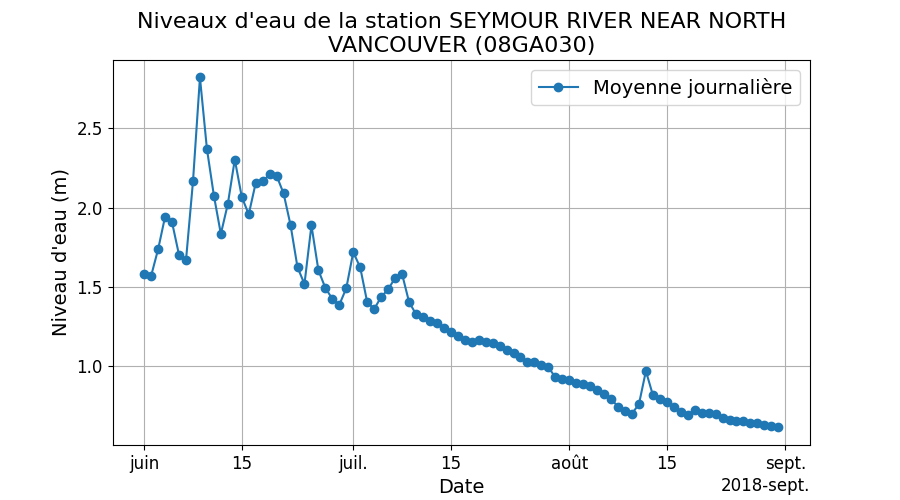

In [7]:
# Création d'un graphique interactif avec Matplotlib

# Station hydrométrique à afficher sur le graphique
station_displayed_p = stations[1]

# Fonction pour créer un graphique pour la station sélectionnée
def interactive_plot(station):
    # Ajustement de la taille des caractères et de la figure
    params = {
        "legend.fontsize": "14",
        "figure.figsize": (9, 5),
        "axes.labelsize": "14",
        "axes.titlesize": "16",
        "xtick.labelsize": "12",
        "ytick.labelsize": "12",
    }
    plt.rcParams.update(params)
    
    # Création du graphique
    fig, ax = plt.subplots()
    line, = plt.plot(
        hydrometric_data[station].index,
        hydrometric_data[station]["LEVEL"],
        marker="o",
        label="Moyenne journalière",
    )
    plt.legend()
    plt.grid(True, which="both")
    ax.set_title(
        fill(
            "Niveaux d'eau de la station {} ({})".format(
                hydrometric_data[station]["STATION_NAME"][0], station
            ), 60
        )
    )
    ax.set_ylabel("Niveau d'eau (m)")
    ax.set_xlabel("Date")

    # Modification de la graduation et des étiquettes de l'axe des x
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    # Création des annotations à afficher au passage de la souris
    annot = ax.annotate(
        "",
        xy=(0, 0),
        xytext=(-60, -40),
        textcoords="offset points",
        bbox=dict(boxstyle="round", fc="w"),
        arrowprops=dict(arrowstyle="->"),
    )
    annot.set_visible(False)

    return line, annot, ax, fig


# Création de la figure
line, annot, ax, fig = interactive_plot(station_displayed_p)


# Mise à jour des annotations avec les informations du point de donnée
def update_annot(ind):
    # Identification des annotations à afficher
    x, y = line.get_data()
    annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
    
    # Ajout de texte à l'annotation (date et niveau d'eau)
    date_x = x[ind["ind"]][0]
    level_y = round(y[ind["ind"]][0], 2)
    text = "{}\nMoyenne journalière: {} m".format(date_x, level_y)
    annot.set_text(text)
    
    # Sélection du niveau de transparence de l'annotation
    annot.get_bbox_patch().set_alpha(0.8)


# Affichage des annotations au passage de la souris
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = line.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()


# Ajout de la fonction d'affichage des annotations au 
# passage de la souris à la figure               
fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()

**Note importante**: Pour que les annotations apparaissent lors du passage de la souris, le code doit être exécuté sur votre ordinateur ou à l'aide de [Jupyter Notebook](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case_oafeat-script_fr.ipynb). Si les annotations ne sont pas visibles au passage de la souris dans Jupyter Notebook, exécutez à nouveau la cellule contenant le code du graphique en cliquant dans la cellule de code ci-dessus puis en cliquant sur le bouton Exécuter dans la barre de menu.

Les données hydrométriques peuvent également être visualisées dans un format tabulaire à l'aide de Pandas.

In [8]:
# Création du tableau

# Station hydrométrique à afficher dans le tableau
station_displayed_t = stations[1]

# Option pour afficher toutes les lignes du tableau
pd.set_option("max_rows", None)


# Fonction pour afficher le tableau de la station sélectionnée
def data_table(station):
    # Impression du titre de la table
    print(
        "Niveaux d'eau de la station "
        + f"{hydrometric_data[station]['STATION_NAME'][0]}"
        + f" ({station})"
    )
    # Sélection des colonnes désirées et modification de leur nom
    displayed_df = hydrometric_data[station][["LEVEL"]].round(2).rename(
        columns={
            "LEVEL": "Moyenne journalière du niveau d'eau (m)",
        }
    )
    displayed_df.index = displayed_df.index.rename("Date")
    return displayed_df

print(tabulate(data_table(station_displayed_t),
               headers='keys',
               tablefmt='pretty'))

Niveaux d'eau de la station SEYMOUR RIVER NEAR NORTH VANCOUVER (08GA030)
+------------+-----------------------------------------+
|    Date    | Moyenne journalière du niveau d'eau (m) |
+------------+-----------------------------------------+
| 2018-06-01 |                  1.58                   |
| 2018-06-02 |                  1.57                   |
| 2018-06-03 |                  1.74                   |
| 2018-06-04 |                  1.94                   |
| 2018-06-05 |                  1.91                   |
| 2018-06-06 |                   1.7                   |
| 2018-06-07 |                  1.67                   |
| 2018-06-08 |                  2.16                   |
| 2018-06-09 |                  2.82                   |
| 2018-06-10 |                  2.37                   |
| 2018-06-11 |                  2.08                   |
| 2018-06-12 |                  1.83                   |
| 2018-06-13 |                  2.02                   |
| 2018-06-14 | 

Finalement, une carte interactive peut être créée avec Matplotlib et Cartopy pour afficher l'ensemble des stations hydrométriques situées dans un rayon de 100 km de Chilliwack. Sur cette carte, la dernière moyenne journalière disponible pour la période de trois mois sélectionnée sera affichées lors du passage de la souris sur sur une station. Pour une carte interactive présentant plus de fonctionnalités comme un contrôle du zoom, une barre d'échelle ou une option d'affichage en plein écran, [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/index.html) peut être utilisé dans un Jupyter Notebook. Un exemple d'utilisation est disponible [dans l'autre version de ce cas d'utilisation](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case_oafeat-interactive_fr.ipynb) qui démontre les possibilités d'interaction plus avancées offertes par Jupyter Notebook.

<IPython.core.display.Javascript object>


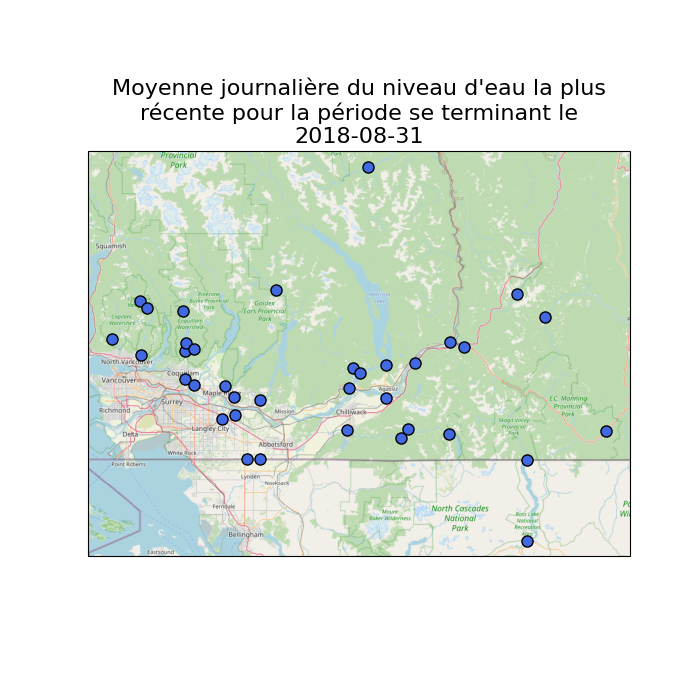

In [9]:
# Création de la carte interactive

# Liste des coordonnées et des étiquettes
labels = []
all_lat = []
all_lon = []
for station in stations:
    latest_data = hydrometric_data[station].iloc[-1]
    labels.append(
        f"{hydrometric_data[station]['STATION_NAME'][0]}\n"
        + f"ID de la station: {latest_data.STATION_NUMBER}\n"
        + f"Date: {latest_data.name}\n"
        + f"Niveau d'eau: {round(latest_data.LEVEL, 2)} m"
    )
    all_lat.append(latest_data.LATITUDE)
    all_lon.append(latest_data.LONGITUDE)

# Liste pour garder une trace de toute les annotations
annotations = [None for label in labels]

# Définition de la taille des marqueurs
markersize = 8
markersize_inches = markersize / 72.0

# Création de la figure
tiler = OSM()
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection=tiler.crs)
ax.set_title(fill(
    "Moyenne journalière du niveau d'eau la plus récente pour "
    + f"la période se terminant le {end_date}", 45)
)

# Définition de l'étendue pour bien voir toutes les stations
ax.set_extent(
    [
        min(all_lon) * 1.001,
        max(all_lon) * 0.999,
        min(all_lat) * 0.999,
        max(all_lat) * 1.001,
    ]
)

# Ajout d'un fond de carte d'Open Street Map
ax.add_image(tiler, 9)

# Ajout des points de données
ax.plot(
    all_lon,
    all_lat,
    "bo",
    marker="o",
    mec="k",
    color="RoyalBlue",
    ms=markersize,
    transform=ccrs.Geodetic(),
)

# Coordonnées de la figure en pouces
trans = ax.transData + fig.dpi_scale_trans.inverted()


# Fonction pour suivre les coordonnées de la souris et annoter
def on_move(event):
    if event.inaxes:
        # Transformation des coordonnées dans la même projection que la figure
        xproj, yproj = zip(
            *[
                ax.projection.transform_point(x, y, src_crs=ccrs.Geodetic())
                for x, y in zip(all_lon, all_lat)
            ]
        )
        # Coordonnées des événements en pouces
        x0, y0 = trans.transform((event.xdata, event.ydata))
        # Coordonnées des stations hydrométriques en pouces
        xfig, yfig = zip(
            *[trans.transform((x, y)) for x, y in zip(xproj, yproj)]
        )
        # Distance entre la souris et la position exacte du point de donnée
        dists = [math.sqrt((x - x0) ** 2 + (y - y0) ** 2) for x, y in zip(
            xfig, yfig
        )]
        
        # Affichage des annotations lors du passage de la souris
        for n, (x, y, dist, label) in enumerate(
                zip(xproj, yproj, dists, labels)
        ):
            if dist < markersize_inches and annotations[n] is None:
                annotations[n] = ax.annotate(
                    label,
                    [x, y],
                    xycoords="data",
                    xytext=(10, 10),
                    textcoords="offset points",
                    ha="center",
                    va="bottom",
                    bbox=dict(
                        facecolor="white",
                        edgecolor="black",
                        boxstyle="round"
                    ),
                    zorder=10,
                )
                fig.canvas.draw()

            elif dist > markersize_inches and annotations[n] is not None:
                annotations[n].remove()
                annotations[n] = None
                fig.canvas.draw()


# Connection du gestionnaire d'événements
cid = fig.canvas.mpl_connect("motion_notify_event", on_move)

plt.show()

**Note importante**: Pour que les annotations apparaissent lors du passage de la souris, le code doit être exécuté sur votre ordinateur ou à l'aide de [Jupyter Notebook](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case_oafeat-script_fr.ipynb). Si les annotations ne sont pas visibles au passage de la souris dans Jupyter Notebook, exécutez à nouveau la cellule contenant le code de la carte en cliquant dans la cellule de code ci-dessus puis en cliquant sur le bouton Exécuter dans la barre de menu.

## Conclusion

Cathy a maintenant un bon aperçu du niveau d'eau des cours d'eau et des étendues d'eau situées près de Chilliwack. Cette information lui sera utile dans la gestion des activités de sa compagnie d'excursions en bateau et de sports nautiques. Suite à la lecture de ce cas d'utilisation, vous devriez être en mesure d'utiliser Python pour récupérer des données géospatiales à partir de GeoMet-OGC-API et d'afficher ces données dans différents formats (graphique interactif, tableau et carte interactive). Ce cas d'utilisation peu être adapté selon vos besoins en modifiant les paramètres ou les étapes de traitement des données.